In [13]:
import os
import pandas as pd

def combine_csv_from_extracted(main_folder_path, output_csv):
    # Define labels for each breathing category
    label_map = {
        "Normal_Breathing": "N",
        "Recovery_Breathing": "R",
        "Endurance_Breathing": "E"
    }
    
    # Verify main folder path
    if not os.path.exists(main_folder_path):
        print(f"Error: Main folder path does not exist -> {main_folder_path}")
        return
    
    print("Available subfolders:", os.listdir(main_folder_path))
    
    # Initialize an empty dataframe
    combined_df = pd.DataFrame()
    
    # Process each subfolder
    for folder, label in label_map.items():
        folder_path = os.path.join(main_folder_path, folder)
        if not os.path.exists(folder_path):
            print(f"Folder not found: {folder_path}")
            continue
        
        csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
        print(f"Processing {len(csv_files)} files in {folder}")
        
        for file in csv_files:
            file_path = os.path.join(folder_path, file)
            df = pd.read_csv(file_path)
            
            # Add label column
            df["Label"] = label
            
            # Append to combined dataframe
            combined_df = pd.concat([combined_df, df], ignore_index=True)
    
    print(f"Total rows in combined dataset: {combined_df.shape[0]}")
    
    # Save the combined dataset
    combined_df.to_csv(output_csv, index=False)
    
    if os.path.exists(output_csv):
        print(f"MainData.csv created successfully at {output_csv}")
    else:
        print("Error: File not created.")

# Example usage
main_folder_path = "C:\Users\ADWIN ADI\\Downloads\\Breathing_Data"
output_csv_path = "C:\\Users\\ADWIN ADI\\Downloads\\MainData.csv"
combine_csv_from_extracted(main_folder_path, output_csv_path)

Available subfolders: ['Endurance_Breathing', 'Normal_Breathing', 'Recovery_Breathing', 'Unknown_Breathing']
Processing 12 files in Normal_Breathing
Processing 11 files in Recovery_Breathing
Processing 11 files in Endurance_Breathing
Total rows in combined dataset: 129898
MainData.csv created successfully at C:\Users\ADWIN ADI\Downloads\MainData.csv


In [19]:
import pandas as pd
import numpy as np

# Function to remove outliers using IQR and replace them with column median
def remove_outliers_iqr(df):
    numeric_cols = df.select_dtypes(include=['number']).columns
    for col in numeric_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        median_value = df[col].median()
        df[col] = np.where((df[col] < lower_bound) | (df[col] > upper_bound), median_value, df[col])
    return df

# Load dataset and clean outliers
df = pd.read_csv("C:\\Users\\ADWIN ADI\\Downloads\\MainData.csv")
df = remove_outliers_iqr(df)

# Save cleaned dataset
df.to_csv("C:\\Users\\ADWIN ADI\\Downloads\\MainData_Outliers_Removed.csv", index=False)

print("Outliers removed using IQR method. Cleaned dataset saved.")

Outliers removed using IQR method. Cleaned dataset saved.


Dataset Shape: (129898, 7)
First Few Rows:
    Sensor1_Temp  Sensor1_Pressure  Sensor1_Humidity  Sensor2_Temp  \
0         33.97          909.5364             78.81         33.96   
1         33.96          909.5364             78.81         33.95   
2         33.95          909.5324             78.99         33.94   
3         33.95          909.5289             79.12         33.94   
4         33.95          909.5289             79.18         33.94   

   Sensor2_Pressure  Sensor2_Humidity Label  
0          909.4451             87.90     N  
1          909.4553             87.90     N  
2          909.4709             87.99     N  
3          909.4604             88.01     N  
4          909.4604             88.01     N  
After Dropping NaN - Shape: (109971, 7)
Epoch 1/50
19/19 [==============================] - 2s 57ms/step - loss: 0.8832 - accuracy: 0.5614 - val_loss: 0.6452 - val_accuracy: 0.7279
Epoch 2/50
19/19 [==============================] - 1s 40ms/step - loss: 0.7248 - ac

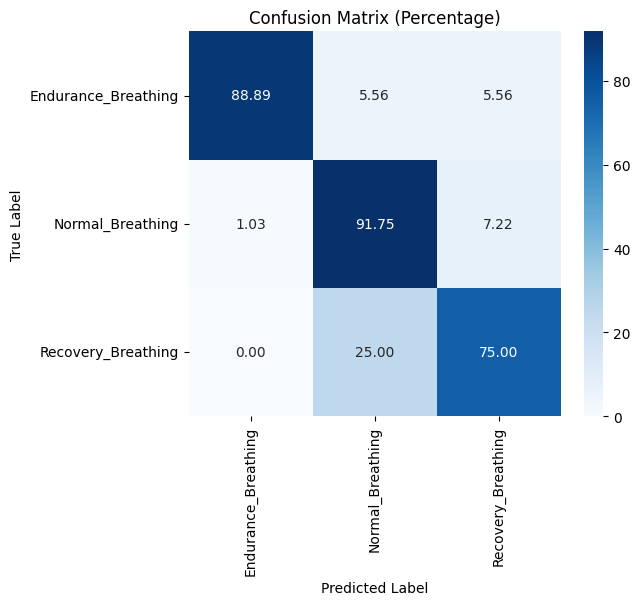

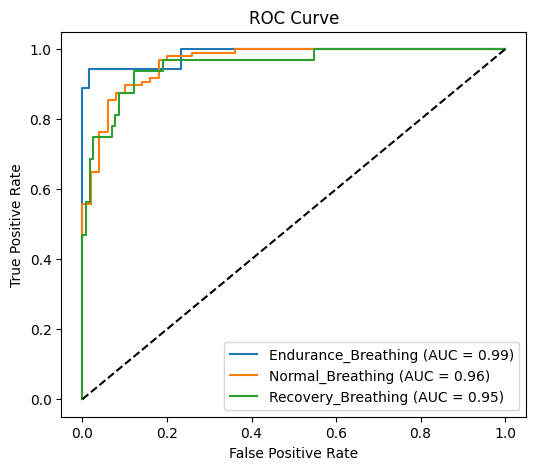

Performance Metrics:
     Metric  Endurance Breathing  Normal Breathing  Recovery Breathing
0      Loss             0.265452          0.265452            0.265452
1  Accuracy             0.877551          0.877551            0.877551
2  F1 Score             0.914286          0.912821            0.750000
Model training completed and saved.


In [16]:

#RNN MODEL
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc,precision_recall_fscore_support
import joblib


# Load dataset
file_path = "C:\\Users\\ADWIN ADI\\Downloads\\breathing.csv files\\MainData_NaN_Outliner_Removed (1).csv"
df = pd.read_csv(file_path)

# Print dataset info
print("Dataset Shape:", df.shape)
print("First Few Rows:\n", df.head())

# Drop NaN values
df.dropna(inplace=True)
print("After Dropping NaN - Shape:", df.shape)

# Ensure dataset is not empty after dropping NaN values
if df.empty:
    raise ValueError("Dataset is empty after dropping NaN values. Check the CSV file!")

# Select features (all columns except the last one) and target (last column)
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
joblib.dump(label_encoder, "/mnt/data/label_encoder.pkl")

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = np.nan_to_num(X_scaled)
joblib.dump(scaler, "/mnt/data/scaler.pkl")

# Verify no NaN values exist
if np.isnan(X_scaled).any() or np.isnan(y_encoded).any():
    raise ValueError("NaN values detected in dataset after preprocessing!")

# Segment data into 10-second windows at 15 Hz (150 samples per segment)
segment_size = 150
num_segments = len(X_scaled) // segment_size
if num_segments == 0:
    raise ValueError(f"Not enough samples for segmentation! Required: {segment_size}, Found: {len(X_scaled)}")

X_segmented = np.array([X_scaled[i * segment_size:(i + 1) * segment_size] for i in range(num_segments)])

def majority_label(labels):
    return np.bincount(labels).argmax()

y_segmented = np.array([majority_label(y_encoded[i * segment_size:(i + 1) * segment_size]) for i in range(num_segments)])

# One-hot encode labels
ohe = OneHotEncoder(sparse_output=False)
y_segmented_ohe = ohe.fit_transform(y_segmented.reshape(-1, 1))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_segmented, y_segmented_ohe, test_size=0.2, random_state=42)

# Build SimpleRNN model
model = Sequential([
    SimpleRNN(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    SimpleRNN(32, return_sequences=False),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(y_train.shape[1], activation='softmax')
])
   

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32)

# Save trained model
model.save("/mnt/data/breathing_pattern_model.h5")

# Predict test labels
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

# Confusion matrix (percentage format)
cm = confusion_matrix(y_test_labels, y_pred)
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(6, 5))
sns.heatmap(cm_percentage, annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=['Endurance_Breathing', 'Normal_Breathing', 'Recovery_Breathing'], 
            yticklabels=['Endurance_Breathing', 'Normal_Breathing', 'Recovery_Breathing'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Percentage)")
plt.show()

# ROC Curve
plt.figure(figsize=(6, 5))
class_labels = ['Endurance_Breathing', 'Normal_Breathing', 'Recovery_Breathing']

for i in range(y_train.shape[1]):
    fpr, tpr, _ = roc_curve(y_test[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_labels[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal reference line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Performance Table
precision, recall, f1, _ = precision_recall_fscore_support(y_test_labels, y_pred, labels=[0, 1, 2])
accuracy = np.mean(y_test_labels == y_pred)
loss = model.evaluate(X_test, y_test, verbose=0)[0]

performance_table = pd.DataFrame({
    "Metric": ["Loss", "Accuracy", "F1 Score"],
    "Endurance Breathing": [loss, accuracy, f1[0]],
    "Normal Breathing": [loss, accuracy, f1[1]],
    "Recovery Breathing": [loss, accuracy, f1[2]]
})

print("Performance Metrics:")
print(performance_table)


print("Model training completed and saved.")

Dataset Shape: (129898, 7)
First Few Rows:
    Sensor1_Temp  Sensor1_Pressure  Sensor1_Humidity  Sensor2_Temp  \
0         33.97          909.5364             78.81         33.96   
1         33.96          909.5364             78.81         33.95   
2         33.95          909.5324             78.99         33.94   
3         33.95          909.5289             79.12         33.94   
4         33.95          909.5289             79.18         33.94   

   Sensor2_Pressure  Sensor2_Humidity Label  
0          909.4451             87.90     N  
1          909.4553             87.90     N  
2          909.4709             87.99     N  
3          909.4604             88.01     N  
4          909.4604             88.01     N  
After Dropping NaN - Shape: (109971, 7)
Epoch 1/50
19/19 [==============================] - 8s 159ms/step - loss: 0.9221 - accuracy: 0.5683 - val_loss: 0.6568 - val_accuracy: 0.7347
Epoch 2/50
19/19 [==============================] - 2s 108ms/step - loss: 0.6767 - 

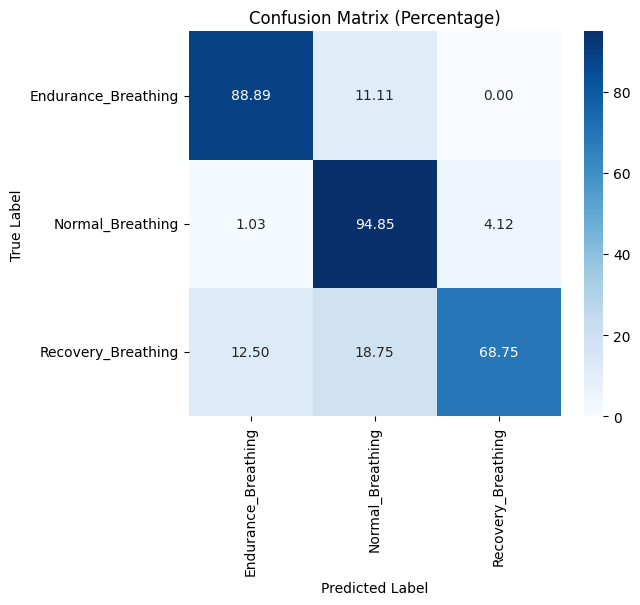

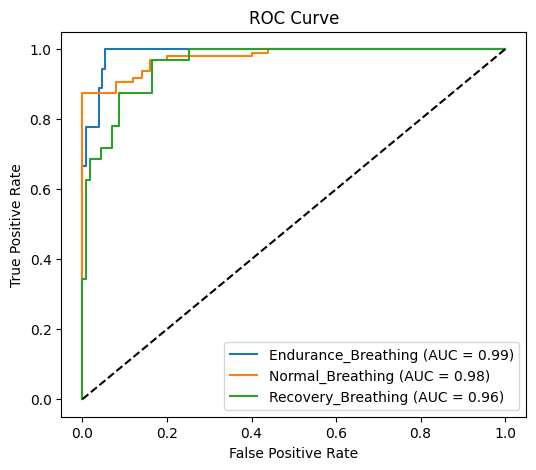

Performance Metrics:
     Metric  Endurance Breathing  Normal Breathing  Recovery Breathing
0      Loss             0.284956          0.284956            0.284956
1  Accuracy             0.884354          0.884354            0.884354
2  F1 Score             0.820513          0.934010            0.758621
Model training completed and saved.


In [15]:
#LSTM MODEL
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc,precision_recall_fscore_support
import joblib

# Load dataset
file_path = "C:\\Users\\ADWIN ADI\\Downloads\\breathing.csv files\\MainData_NaN_Outliner_Removed (1).csv"
df = pd.read_csv(file_path)

# Print dataset info
print("Dataset Shape:", df.shape)
print("First Few Rows:\n", df.head())

# Drop NaN values
df.dropna(inplace=True)
print("After Dropping NaN - Shape:", df.shape)

# Ensure dataset is not empty after dropping NaN values
if df.empty:
    raise ValueError("Dataset is empty after dropping NaN values. Check the CSV file!")

# Select features (all columns except the last one) and target (last column)
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
joblib.dump(label_encoder, "/mnt/data/label_encoder.pkl")

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = np.nan_to_num(X_scaled)
joblib.dump(scaler, "/mnt/data/scaler.pkl")

# Verify no NaN values exist
if np.isnan(X_scaled).any() or np.isnan(y_encoded).any():
    raise ValueError("NaN values detected in dataset after preprocessing!")

# Segment data into 10-second windows at 15 Hz (150 samples per segment)
segment_size = 150
num_segments = len(X_scaled) // segment_size
if num_segments == 0:
    raise ValueError(f"Not enough samples for segmentation! Required: {segment_size}, Found: {len(X_scaled)}")

X_segmented = np.array([X_scaled[i * segment_size:(i + 1) * segment_size] for i in range(num_segments)])

def majority_label(labels):
    return np.bincount(labels).argmax()

y_segmented = np.array([majority_label(y_encoded[i * segment_size:(i + 1) * segment_size]) for i in range(num_segments)])

# One-hot encode labels
ohe = OneHotEncoder(sparse_output=False)
y_segmented_ohe = ohe.fit_transform(y_segmented.reshape(-1, 1))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_segmented, y_segmented_ohe, test_size=0.2, random_state=42)

# Build LSTM model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(y_train.shape[1], activation='softmax')
])

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32)

# Save trained model
model.save("/mnt/data/breathing_pattern_model.h5")

# Predict test labels
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

# Confusion matrix (percentage format)
cm = confusion_matrix(y_test_labels, y_pred)
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(6, 5))
sns.heatmap(cm_percentage, annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=['Endurance_Breathing', 'Normal_Breathing', 'Recovery_Breathing'], 
            yticklabels=['Endurance_Breathing', 'Normal_Breathing', 'Recovery_Breathing'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Percentage)")
plt.show()

# ROC Curve
plt.figure(figsize=(6, 5))
class_labels = ['Endurance_Breathing', 'Normal_Breathing', 'Recovery_Breathing']

for i in range(y_train.shape[1]):
    fpr, tpr, _ = roc_curve(y_test[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_labels[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal reference line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Performance Table
precision, recall, f1, _ = precision_recall_fscore_support(y_test_labels, y_pred, labels=[0, 1, 2])
accuracy = np.mean(y_test_labels == y_pred)
loss = model.evaluate(X_test, y_test, verbose=0)[0]

performance_table = pd.DataFrame({
    "Metric": ["Loss", "Accuracy", "F1 Score"],
    "Endurance Breathing": [loss, accuracy, f1[0]],
    "Normal Breathing": [loss, accuracy, f1[1]],
    "Recovery Breathing": [loss, accuracy, f1[2]]
})

print("Performance Metrics:")
print(performance_table)
print("Model training completed and saved.")


Dataset Shape: (129898, 7)
First Few Rows:
    Sensor1_Temp  Sensor1_Pressure  Sensor1_Humidity  Sensor2_Temp  \
0         33.97          909.5364             78.81         33.96   
1         33.96          909.5364             78.81         33.95   
2         33.95          909.5324             78.99         33.94   
3         33.95          909.5289             79.12         33.94   
4         33.95          909.5289             79.18         33.94   

   Sensor2_Pressure  Sensor2_Humidity Label  
0          909.4451             87.90     N  
1          909.4553             87.90     N  
2          909.4709             87.99     N  
3          909.4604             88.01     N  
4          909.4604             88.01     N  
After Dropping NaN - Shape: (109971, 7)
Epoch 1/50
19/19 [==============================] - 12s 268ms/step - loss: 0.9949 - accuracy: 0.5563 - val_loss: 0.8133 - val_accuracy: 0.7415
Epoch 2/50
19/19 [==============================] - 4s 187ms/step - loss: 0.7673 -

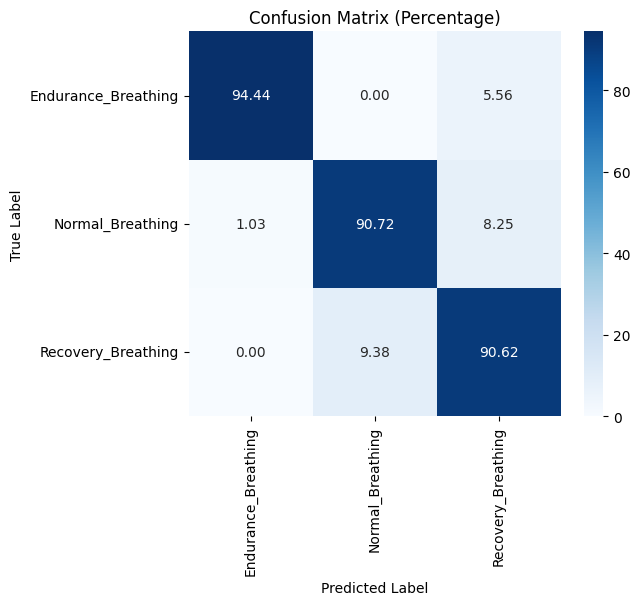

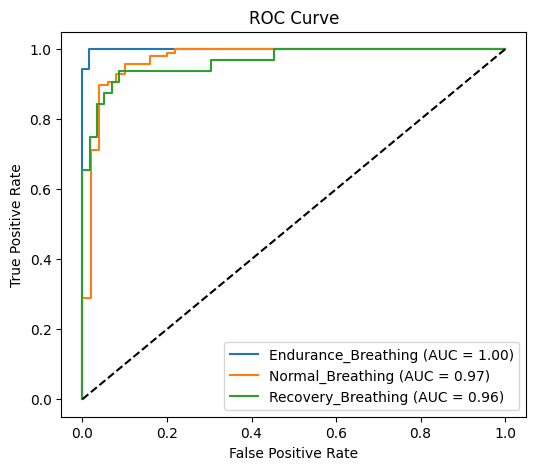

Model training completed and saved.


In [13]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc,precision_recall_fscore_support
import joblib

# Load dataset
file_path ="C:\\Users\\ADWIN ADI\\Downloads\\breathing.csv files\\MainData_NaN_Outliner_Removed (1).csv"
df = pd.read_csv(file_path)

# Print dataset info
print("Dataset Shape:", df.shape)
print("First Few Rows:\n", df.head())

# Drop NaN values
df.dropna(inplace=True)
print("After Dropping NaN - Shape:", df.shape)

# Ensure dataset is not empty after dropping NaN values
if df.empty:
    raise ValueError("Dataset is empty after dropping NaN values. Check the CSV file!")

# Select features (all columns except the last one) and target (last column)
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
joblib.dump(label_encoder, "/mnt/data/label_encoder.pkl")

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = np.nan_to_num(X_scaled)
joblib.dump(scaler, "/mnt/data/scaler.pkl")

# Verify no NaN values exist
if np.isnan(X_scaled).any() or np.isnan(y_encoded).any():
    raise ValueError("NaN values detected in dataset after preprocessing!")

# Segment data into 10-second windows at 15 Hz (150 samples per segment)
segment_size = 150
num_segments = len(X_scaled) // segment_size
if num_segments == 0:
    raise ValueError(f"Not enough samples for segmentation! Required: {segment_size}, Found: {len(X_scaled)}")

X_segmented = np.array([X_scaled[i * segment_size:(i + 1) * segment_size] for i in range(num_segments)])

def majority_label(labels):
    return np.bincount(labels).argmax()

y_segmented = np.array([majority_label(y_encoded[i * segment_size:(i + 1) * segment_size]) for i in range(num_segments)])

# One-hot encode labels
ohe = OneHotEncoder(sparse_output=False)
y_segmented_ohe = ohe.fit_transform(y_segmented.reshape(-1, 1))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_segmented, y_segmented_ohe, test_size=0.2, random_state=42)

# Build GRU model
model = Sequential([
    GRU(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    GRU(32, return_sequences=False),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(y_train.shape[1], activation='softmax')
])

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32)

# Save trained model
model.save("/mnt/data/breathing_pattern_model.h5")

# Predict test labels
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

# Confusion matrix (percentage format)
cm = confusion_matrix(y_test_labels, y_pred)
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(6, 5))
sns.heatmap(cm_percentage, annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=['Endurance_Breathing', 'Normal_Breathing', 'Recovery_Breathing'], 
            yticklabels=['Endurance_Breathing', 'Normal_Breathing', 'Recovery_Breathing'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Percentage)")
plt.show()

# ROC Curve
plt.figure(figsize=(6, 5))
class_labels = ['Endurance_Breathing', 'Normal_Breathing', 'Recovery_Breathing']

for i in range(y_train.shape[1]):
    fpr, tpr, _ = roc_curve(y_test[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_labels[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal reference line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Performance Table
precision, recall, f1, _ = precision_recall_fscore_support(y_test_labels, y_pred, labels=[0, 1, 2])
accuracy = np.mean(y_test_labels == y_pred)
loss = model.evaluate(X_test, y_test, verbose=0)[0]

performance_table = pd.DataFrame({
    "Metric": ["Loss", "Accuracy", "F1 Score"],
    "Endurance Breathing": [loss, accuracy, f1[0]],
    "Normal Breathing": [loss, accuracy, f1[1]],
    "Recovery Breathing": [loss, accuracy, f1[2]]
})

print("Performance Metrics:")
print(performance_table)
print("Model training completed and saved.")


Dataset Shape: (129898, 7)
First Few Rows:
    Sensor1_Temp  Sensor1_Pressure  Sensor1_Humidity  Sensor2_Temp  \
0         33.97          909.5364             78.81         33.96   
1         33.96          909.5364             78.81         33.95   
2         33.95          909.5324             78.99         33.94   
3         33.95          909.5289             79.12         33.94   
4         33.95          909.5289             79.18         33.94   

   Sensor2_Pressure  Sensor2_Humidity Label  
0          909.4451             87.90     N  
1          909.4553             87.90     N  
2          909.4709             87.99     N  
3          909.4604             88.01     N  
4          909.4604             88.01     N  
After Dropping NaN - Shape: (109971, 7)
Epoch 1/50
19/19 [==============================] - 22s 378ms/step - loss: 0.8988 - accuracy: 0.5666 - val_loss: 0.6333 - val_accuracy: 0.7415
Epoch 2/50
19/19 [==============================] - 3s 185ms/step - loss: 0.6839 -

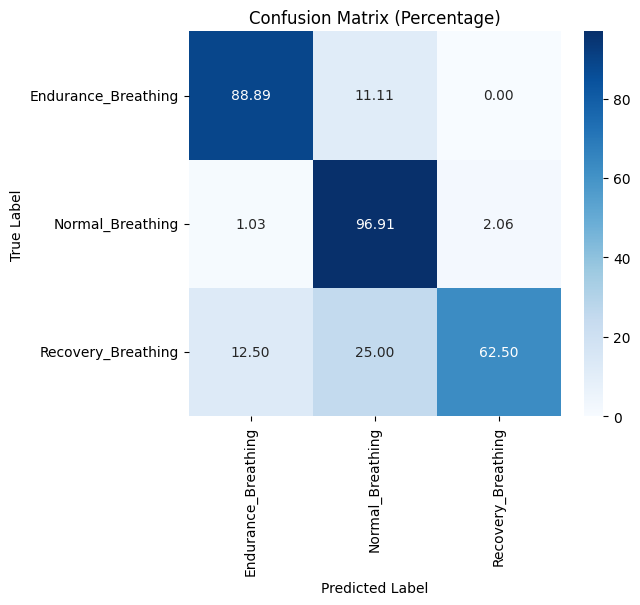

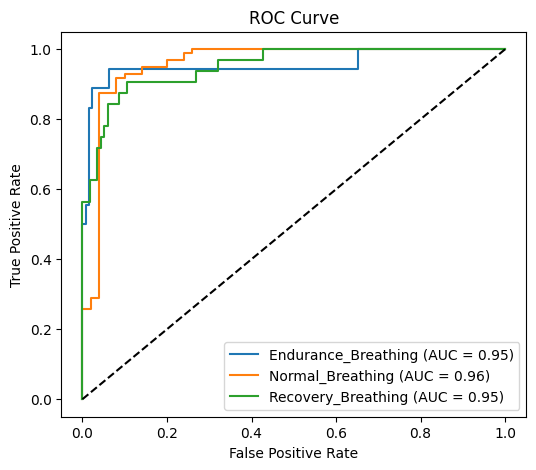

Performance Metrics:
     Metric  Endurance Breathing  Normal Breathing  Recovery Breathing
0      Loss             0.319824          0.319824            0.319824
1  Accuracy             0.884354          0.884354            0.884354
2  F1 Score             0.820513          0.935323            0.740741
 Ensemble model training completed and saved.


In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, Dense, Dropout, Input, concatenate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_fscore_support
import joblib

# Load dataset
file_path = "C:\\Users\\ADWIN ADI\\Downloads\\breathing.csv files\\MainData_NaN_Outliner_Removed (1).csv"
df = pd.read_csv(file_path)

# Dataset Info
print("Dataset Shape:", df.shape)
print("First Few Rows:\n", df.head())

# Drop NaN values
df.dropna(inplace=True)
print("After Dropping NaN - Shape:", df.shape)

if df.empty:
    raise ValueError("Dataset is empty after dropping NaN values. Check the CSV file!")

# Features and Labels
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

# Encode Labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
joblib.dump(label_encoder, "/mnt/data/label_encoder.pkl")

# Normalize Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = np.nan_to_num(X_scaled)
joblib.dump(scaler, "/mnt/data/scaler.pkl")

# Check for NaNs
if np.isnan(X_scaled).any() or np.isnan(y_encoded).any():
    raise ValueError("NaN values detected after preprocessing!")

# Segmenting
segment_size = 150
num_segments = len(X_scaled) // segment_size
if num_segments == 0:
    raise ValueError(f"Not enough samples for segmentation! Required: {segment_size}, Found: {len(X_scaled)}")

X_segmented = np.array([X_scaled[i * segment_size:(i + 1) * segment_size] for i in range(num_segments)])

def majority_label(labels):
    return np.bincount(labels).argmax()

y_segmented = np.array([majority_label(y_encoded[i * segment_size:(i + 1) * segment_size]) for i in range(num_segments)])

# One-hot encode labels
ohe = OneHotEncoder(sparse_output=False)
y_segmented_ohe = ohe.fit_transform(y_segmented.reshape(-1, 1))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_segmented, y_segmented_ohe, test_size=0.2, random_state=42)

# Ensemble Model Architecture
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))

# LSTM Branch
lstm_branch = LSTM(64, return_sequences=True)(input_layer)
lstm_branch = Dropout(0.2)(lstm_branch)
lstm_branch = LSTM(32, return_sequences=False)(lstm_branch)
lstm_branch = Dropout(0.2)(lstm_branch)

# GRU Branch
gru_branch = GRU(64, return_sequences=True)(input_layer)
gru_branch = Dropout(0.2)(gru_branch)
gru_branch = GRU(32, return_sequences=False)(gru_branch)
gru_branch = Dropout(0.2)(gru_branch)

# SimpleRNN Branch 
rnn_branch = SimpleRNN(64, return_sequences=True)(input_layer)
rnn_branch = Dropout(0.2)(rnn_branch)
rnn_branch = SimpleRNN(32, return_sequences=False)(rnn_branch)
rnn_branch = Dropout(0.2)(rnn_branch)

# Concatenate
merged = concatenate([lstm_branch, gru_branch, rnn_branch])
merged = Dense(16, activation='relu')(merged)
out_layer = Dense(y_train.shape[1], activation='softmax')(merged)

# Compile Model
model = Model(inputs=input_layer, outputs=out_layer)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32)

# Save Model
model.save("/mnt/data/breathing_pattern_ensemble_model.h5")

# Prediction
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_test_labels, y_pred)
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(6, 5))
sns.heatmap(cm_percentage, annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=['Endurance_Breathing', 'Normal_Breathing', 'Recovery_Breathing'], 
            yticklabels=['Endurance_Breathing', 'Normal_Breathing', 'Recovery_Breathing'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Percentage)")
plt.show()

# ROC Curve
plt.figure(figsize=(6, 5))
class_labels = ['Endurance_Breathing', 'Normal_Breathing', 'Recovery_Breathing']

for i in range(y_train.shape[1]):
    fpr, tpr, _ = roc_curve(y_test[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_labels[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Performance Table
precision, recall, f1, _ = precision_recall_fscore_support(y_test_labels, y_pred, labels=[0, 1, 2])
accuracy = np.mean(y_test_labels == y_pred)
loss = model.evaluate(X_test, y_test, verbose=0)[0]

performance_table = pd.DataFrame({
    "Metric": ["Loss", "Accuracy", "F1 Score"],
    "Endurance Breathing": [loss, accuracy, f1[0]],
    "Normal Breathing": [loss, accuracy, f1[1]],
    "Recovery Breathing": [loss, accuracy, f1[2]]
})

print("Performance Metrics:")
print(performance_table)
print(" Ensemble model training completed and saved.")
